<a href="https://colab.research.google.com/github/hasune613/hello-world/blob/main/%E5%B2%A9%E6%B3%A2__0NE_shoT_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* ATE: Average Treatment Effect(平均処置効果) \\
    集団全体における、平均的な介入の効果 \\
$$
ATE=E(Y1)−E(Y0)
$$

* ATT: Average Treatment effect on the Treated (処置群における平均処置効果) \\
    処置群（介入ありグループ）における、平均的な介入の効果 \\
$$
ATT=E(Y1|Z=1)−E(Y0|Z=1)
$$
* ATU: Average Treatment effect on the Untreated (対照群における平均処置効果) \\
    対照群（介入なしグループ）における、平均的な介入の効果 \\
$$
ATU=E(Y1|Z=0)−E(Y0|Z=0)
$$


## 岩波DS vol.3のCM接触効果推定
CMを放映でアプリ利用がどれくらい増加するか \\
CM施策による直接的な利益（＝アプリを利用するユーザーの増加割合）を推定するため、ATTを推定。
1.    傾向スコア推定モデルを構築
2.    傾向スコア推定モデルの推定精度を確認
3.    ATTを算出


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import statsmodels.api as sm
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score

import itertools
import time



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
path = 'https://raw.githubusercontent.com/iwanami-datascience/vol3/master/kato%26hoshino/q_data_x.csv'

In [ ]:
data = pd.read_csv(path)

In [ ]:
data.columns

Index(['cm_dummy', 'gamedummy', 'area_kanto', 'area_keihan', 'area_tokai',
       'area_keihanshin', 'age', 'sex', 'marry_dummy', 'job_dummy1',
       'job_dummy2', 'job_dummy3', 'job_dummy4', 'job_dummy5', 'job_dummy6',
       'job_dummy7', 'job_dummy8', 'inc', 'pmoney', 'fam_str_dummy1',
       'fam_str_dummy2', 'fam_str_dummy3', 'fam_str_dummy4', 'fam_str_dummy5',
       'child_dummy', 'T', 'F1', 'F2', 'F3', 'M1', 'M2', 'M3', 'TVwatch_day',
       'gamesecond', 'gamecount'],
      dtype='object')

In [ ]:
#共変量(TV視聴時間、性別、年齢etc...)
X = data[[
          'TVwatch_day',
          'age','sex','marry_dummy','child_dummy','inc','pmoney',
          'job_dummy1','job_dummy2', 'job_dummy3', 'job_dummy4', 'job_dummy5', 'job_dummy6',
          'job_dummy7','fam_str_dummy1','fam_str_dummy2', 'fam_str_dummy3', 'fam_str_dummy4'         
]]

#群別変数(TVを見た/見ていない)
Z = data['cm_dummy']

In [ ]:
X.head()

,TVwatch_day,age,sex,marry_dummy,child_dummy,inc,pmoney,job_dummy1,job_dummy2,job_dummy3,job_dummy4,job_dummy5,job_dummy6,job_dummy7,fam_str_dummy1,fam_str_dummy2,fam_str_dummy3,fam_str_dummy4
0,33.427600,44.5,1,1,1,249.5,0.0,1,0,0,0,0,0,0,0,0,1,0
1,31.542862,34.5,1,1,1,800.0,12.5,1,0,0,0,0,0,0,0,0,1,0
2,37.825805,24.5,1,0,0,0.0,2.0,0,0,0,0,0,0,1,0,0,0,1
3,36.345911,44.5,1,1,1,800.0,2.0,1,0,0,0,0,0,0,0,0,1,0
4,49.344942,34.5,1,1,1,749.5,4.0,1,0,0,0,0,0,0,0,0,1,0


In [ ]:
X.columns.value_counts().sum()

18

In [ ]:
Z.head()

0    0
1    0
2    0
3    0
4    0
Name: cm_dummy, dtype: int64

In [ ]:
#傾向スコアの推定
exog = sm.add_constant(X)#切片の追加
# exog.columns.value_counts().sum()
logit_model = sm.Logit(Z, exog)
logit_res = logit_model.fit()


Optimization terminated successfully.
         Current function value: 0.597316
         Iterations 5


In [ ]:
#ATTの推定
ps = logit_res.predict(exog)
print(f'AUC = {roc_auc_score(Z,ps):.3f}')

AUC = 0.733


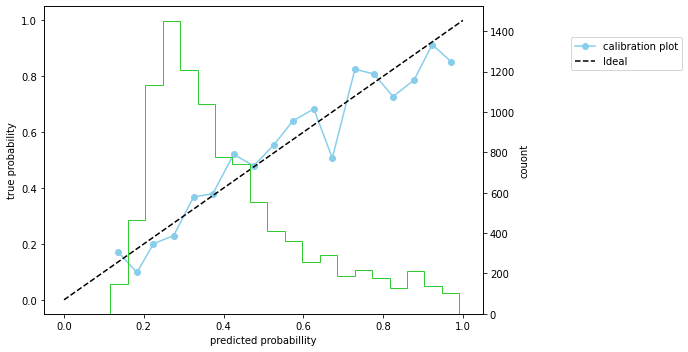

In [ ]:
# キャリブレーションプロットを描画
_, ax1 = plt.subplots(figsize=(10,5))

prod_true, prod_pred = calibration_curve(Z, ps, n_bins=20)
ax1.plot(prod_pred, prod_true, marker = 'o', label = 'calibration plot',color='skyblue')
ax1.plot([0,1],[0,1],linestyle='--',color = 'black',label='ldeal')
ax1.legend(bbox_to_anchor=(1.2,0.9), loc='upper left',borderaxespad=0)
ax1.set_xlabel('predicted probabillity')
ax1.set_ylabel('true probability')

ax2 = ax1.twinx()
ax2.hist(ps, bins=20, histtype = 'step', rwidth = 0.9,color='limegreen')
ax2.set_ylabel('couont')
plt.tight_layout()
plt.show()

In [ ]:
#ATTの推定

Y = data['gamedummy']#結果変数（推定対象）
sample_size = len(data.loc[data['cm_dummy']==1])
ATT_list = []

for i in range(100):
    idx1 = pd.Series(data.loc[data['cm_dummy']==1, 'gamedummy'].index).sample(n=sample_size, replace=True, random_state=i)
    idx0 = pd.Series(data.loc[data['cm_dummy']==0, 'gamedummy'].index).sample(n=sample_size, replace=True, random_state=i)

    z_tmp = np.r_[Z[idx1], Z[idx0]]
    Y_tmp = np.r_[Y[idx1], Y[idx0]]
    ps_tmp = np.r_[ps[idx1], ps[idx0]]
    w01_tmp = (1-z_tmp)*ps_tmp/ (1-ps_tmp)

    E1 = np.mean(Y_tmp[z_tmp == 1])
    E0 = np.sum(Y_tmp * w01_tmp) / np.sum(w01_tmp)
    ATT = E1 - E0
    ATT_list.append(ATT)

print(f'ATT = {np.mean(ATT_list):.3f} ±{np.std(ATT_list) * 1.96} (s.d = {np.std(ATT_list):.3f})')

ATT = 0.024 ±0.011902487479350535 (s.d = 0.006)
